### Basic Neural Network

Creating a basic neural network using the MNIST dataset

**Date:** 30/10/2021  
**Author:** Murad Popattia

### Importing the libraries

In [69]:
# import libraries
import torch
import torch.nn as nn # all the layers
import torch.optim as optim # all the optimization algos
import torch.nn.functional as F # all the activation functions
from torch.utils.data import DataLoader # helps to create mini-batches etc.
import torchvision.datasets as datasets # for getting all datasets
import torchvision.transforms as transforms # for transformations on the dataset
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score

### Creating the model

In [2]:
# create FNN
class NN(nn.Module):
    def __init__(self, input_size, num_classes): # 784 input size as the images are 28 * 28
        super().__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes) # output of the network

    def forward(self, x):
        x = F.relu(self.fc1(x)) # adding non-linearity
        x = self.fc2(x)
        return x

Making sure the NN is properly made

In [3]:
# checking the NN

model = NN(784, 10)
features = torch.rand(64,784) # no. of examples
output = model(features)
print(output.shape) # output should be no. of examples x num_classes

torch.Size([64, 10])


### Setting the device

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Initializing hyperparams

In [5]:
# hyper params
input_size = 28 * 28
num_classes = 10
lr = 0.001
batch_size = 64
num_epochs = 5

### Loading the dataset and creating dataloader

Also transforming the dataset to convert them to tensors before sending to the model

In [13]:
train_dataset = datasets.MNIST(root='./datasets/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./datasets/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True)

### Analyzing the data

In [7]:
train_images = train_dataset.data
train_images.shape

torch.Size([60000, 28, 28])

In [8]:
# adding channel dimension to display
train_images.unsqueeze_(1)
train_images.shape

torch.Size([60000, 1, 28, 28])

torch.Size([3, 152, 242])


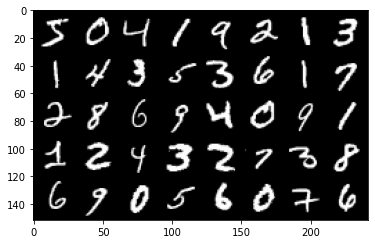

In [9]:
# helper function of displaying the dataset
def show(img):
    npimg = img.numpy() # convert the tensor to numpy

    # convert to h*w*c from c*h*w
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    
x_grid = utils.make_grid(train_images[:40], nrow = 8) # nrow means the no. of images per column
print(x_grid.shape)
show(x_grid)

### Initializing the network

In [59]:
# initialize the network
model = NN(input_size=input_size, num_classes=num_classes).to(device) # sending model to device

In [60]:
from torchsummary import summary

summary(model, input_size=(input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]          39,250
            Linear-2                   [-1, 10]             510
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


### Initializing loss and optimizer

In [61]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [62]:
for epoch in range(num_epochs):  # 1 epoch means the model has seen all the images
    total_loss = 0
    counter = 0 
    
    n_batches = len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}')
    pbar = tf.keras.utils.Progbar(target=n_batches)
    
    # Training
    model.train()
    
    for idx, (data, target) in enumerate(train_loader):  # enumerating to see the batch idx
        
        # get data to cuda if possible
        data = data.to(device)
        target = target.to(device)

        # torch.Size([64, 1, 28, 28])
        # data.shape[0] refers to batch size
        # flattening the output to get correct shop
        data = data.reshape(data.shape[0], -1)
        
        # foward
        scores = model(data)  
        loss = criterion(scores, target)
        total_loss += loss
        
        pbar.update(idx, values=[("loss",loss.item())])
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        # gradient descent step
        optimizer.step()
        
        # increment for every batch
        counter += 1
        
    # for every epoch calculate test loss
    # validation
    model.eval()
    
    for idx, (data, target) in enumerate(test_loader):
        with torch.no_grad(): # no computation for gradients
            # get data to cuda
            data = data.to(device)
            target = target.to(device)

            data = data.reshape(data.shape[0], -1)

            scores = model(data)
            loss = criterion(scores, target)
            
            pbar.update(idx, values=[("validation loss",loss.item())])
    
    pbar.update(n_batches, values=None)

Epoch 1/5
938/938 [==============================] - 8s 8ms/step - loss: 0.4133 - validation loss: 0.2455
Epoch 2/5
938/938 [==============================] - 8s 8ms/step - loss: 0.2095 - validation loss: 0.1737
Epoch 3/5
938/938 [==============================] - 8s 1ms/step - loss: 0.1558 - validation loss: 0.1433
Epoch 4/5
938/938 [==============================] - 8s 8ms/step - loss: 0.1265 - validation loss: 0.1271
Epoch 5/5
938/938 [==============================] - 8s 1ms/step - loss: 0.1061 - validation loss: 0.1117


### Checking the accuracy of the model

In [126]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    output_gt = []
    output_pred = []
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            x = x.reshape(x.shape[0], -1)
            
            scores = model(x)
            _, predictions = scores.max(1) # .max() return max value and indices
            
            output_gt.extend(y.cpu().numpy())
            output_pred.extend(predictions.cpu().numpy())
        
        if (loader.dataset.train):
            print("Training Metrics: ")
        else:
            print("Testing Metrics: ")
        print(f'Precision: {precision_score(output_gt, output_pred, average="micro")}')
        print(f'Recall: {recall_score(output_gt, output_pred, average="micro")}')
        print(f'F1_score: {f1_score(output_gt, output_pred, average="micro")}')

In [128]:
check_accuracy(train_loader, model)

Training Metrics: 
Precision: 0.9742333333333333
Recall: 0.9742333333333333
F1_score: 0.9742333333333333


In [129]:
check_accuracy(test_loader, model)

Testing Metrics: 
Precision: 0.9672
Recall: 0.9672
F1_score: 0.9672
